In [2]:
%matplotlib inline


# Multi-dimensional scaling

An illustration of the metric and non-metric MDS on generated noisy data.

The reconstructed points using the metric MDS and non metric MDS are slightly
shifted to avoid overlapping.


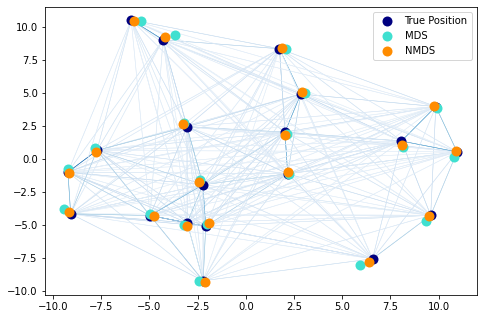

In [3]:
# Author: Nelle Varoquaux <nelle.varoquaux@gmail.com>
# License: BSD

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

EPSILON = np.finfo(np.float32).eps
n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(float)
X_true = X_true.reshape((n_samples, 2))
# Center the data
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise

mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
)
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
pos *= np.sqrt((X_true**2).sum()) / np.sqrt((pos**2).sum())
npos *= np.sqrt((X_true**2).sum()) / np.sqrt((npos**2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0.0, 0.0, 1.0, 1.0])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color="navy", s=s, lw=0, label="True Position")
plt.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
plt.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label="NMDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

similarities = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities, 0)
# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [X_true[i, :], X_true[j, :]] for i in range(len(pos)) for j in range(len(pos))
]
values = np.abs(similarities)
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max())
)
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

plt.show()